In [ ]:
#%%
# path to working directory
path = '/Users/davidnordfors/galvanize/galvanize-capstone/final'

# IMPORT LIBRARIES
## OS
import os
os.chdir(path)

# MANAGE
import pandas as pd
import numpy as np
#from collections import Counter
from boolma import BM

## FIT
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

## DECOMPOSITION
from sklearn.decomposition import NMF
from scipy.linalg import svd

## GRAPHICS
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

def dist_boxplot(x, **kwargs):
    ax = sns.distplot(x, hist_kws=dict(alpha=0.2))
    ax2 = ax.twinx()
    sns.boxplot(x=x, ax=ax2)
    ax2.set(ylim=(-5, 5))


#%% DATA
## I/O
import zipfile
import requests
import pickle

# Normalization function
def norm(vec):
    return (vec-vec.mean())/vec.std()

# READ O*NET DATABASE. Search order: Dictionary, Pickle, Excel; Create dictionary/pickle if non-existent.
onet = {}
def from_onet(qualities):
        if qualities in onet:
                return onet[qualities]
        pickle_exists = os.path.isfile('./data/pickle/'+qualities+'.pkl')
        if pickle_exists:
                onet[qualities] = pd.read_pickle('./data/pickle/'+qualities+'.pkl')
                return onet[qualities]
        else: 
                onet[qualities]= pd.read_excel(
                        zipfile.ZipFile('./data/db_23_2_excel.zip').extract(
                        'db_23_2_excel/'+qualities+'.xlsx'))
                onet[qualities].to_pickle('./data/pickle/'+qualities+'.pkl')
                return onet[qualities]


# format and Strip O*NET SOC occupation codes to match the ones used by Census PUMS
def soc(socc):
    code = str(socc).replace('-','')
    return code[:6]

# CENSUS DATA: select workers in ages 40 - 65 and discard the occupations with large standard deviations.
all_workers = pd.read_pickle('data/pickle/pums_California.pkl')
workers = BM(all_workers).select(
            'AGEP','gt',40).select(
            'AGEP','lt',65).df
workers['log FTE'] = workers['FTE wage'].apply(np.log)
foo = workers.groupby('SOCP') 
all_occupations = foo.mean()[['AGEP', 'FTE wage','log FTE']]
all_occupations['count'] = foo.count()['AGEP']
all_occupations['std log FTE'] = foo.std()['log FTE']
all_occupations['SOCP'] = all_occupations.index
all_occupations['SOCP_shave'] = all_occupations['SOCP'].apply(soc)
all_occupations['Occupation'] = all_occupations['SOCP']
occupations = all_occupations[all_occupations['std log FTE']<0.50]

#%%  CREATE X:features from O*NET; and y: mean wages from census/pums

def matrix(features):
    # Build X: occupation/feature matrix from O*NET
    foo = pd.get_dummies(features['Element Name']) 
    occ_features = features[['O*NET-SOC Code']].join(foo.multiply(features['Data Value'],axis = "index")).groupby('O*NET-SOC Code').sum()
    occ_features['SOCP'] = occ_features.index
    occ_features['SOCP_shave']=occ_features['SOCP'].apply(soc)
    # Group by census/PUMS SOC codes (SOCP_shave)
    occ_features_compounded= occ_features.groupby('SOCP_shave').mean()
    occ_features_compounded['SOCP_shave'] = occ_features_compounded.index   
    foo = occ_features_compounded.drop(columns='SOCP_shave')
    return foo

def xy(features,occupations):
    #Normalizes occupation matrix
    foo = matrix(features)
    occ_features_norm = (foo - foo.mean())/foo.std()
    

    # Normalize y:  Census/PUMS log FTE wages   
    foo = occupations[['SOCP_shave','Occupation','FTE wage','log FTE']].copy()
    foo['log FTE'] =norm(occupations['log FTE'])

    # Merge and align X & y for occupations
    fit_data = foo.merge(occ_features_norm,left_on='SOCP_shave',right_index=True)
    
    # Return X & y
    y = fit_data['log FTE']
    X = fit_data.drop(columns = ['SOCP_shave', 'Occupation', 'FTE wage', 'log FTE'])
    return (X,y)


# SELECT FEATURE SETS FROM O*NET, FIT FOR O*NET FTE WAGES 

# Prepare feature sets.
def prepare(df):
    # For Abilities, Knowledge, Skills
    if 'LV' in set(df['Scale ID']):
        sid = 'LV'
    # For Interests
    elif 'OI' in set(df['Scale ID']):
        sid = 'OI'
    df = df[df['Scale ID'] == sid]

    return df[['O*NET-SOC Code','Element Name','Data Value']]
        

dab = prepare(from_onet('Abilities'))
dkn = prepare(from_onet('Knowledge'))
dsk = prepare(from_onet('Skills'))
din = prepare(from_onet('Interests'))

In [65]:
featuresets = [dab,dkn,dsk,din]
featurenames = ['Abilities','Knowledge','Skills','Interests']
methodnames = ['Ridge','Random Forest','Boost']

In [123]:
#%% MODEL & FIT

reg_ridge = linear_model.Ridge(alpha=.5)
rf = RandomForestRegressor(n_estimators=40,
                           max_features='auto',
                           random_state=0)


fit = {}
feat = {}
result = {}
n=4
for ft in range(len(featuresets)):
    X, y = xy(featuresets[ft],occupations)
    res = cross_validate(rf,X, y, cv=n, return_estimator=True)
    result[ft] = res
    feat[ft] = pd.DataFrame(res['estimator'][0].feature_importances_,index=X.columns)
    for i in range(n):
        feat[ft][i] = pd.DataFrame(res['estimator'][i].feature_importances_,index=X.columns)
    feat[ft]['mean'] = feat[ft].mean(axis=1)
    feat[ft]['std'] = feat[ft].std(axis=1)


# CLUSTER FEATURES INTO OCCUPATION CATEGORIES
# Use non-zero matrix factorization for clustering
# Use singular value decomposition first state for determining overall similarity

class OnetCluster:
    def __init__(self,X,n):
        self.X = X
        self.model = NMF(n_components=n, init='random', random_state=0, max_iter = 1000, tol = 0.0000001)
        self.w = self.model.fit_transform(X)
        self.pw = pd.DataFrame(self.w,index=X.index)
        self.pwn = nrmcol(self.pw.T).T
        self.h = self.model.components_
        self.ph = pd.DataFrame(self.h,columns=X.columns)
        self.phn = nrmcol(self.ph.T).T


class Svd:
    def __init__(self,X):
        self.u,self.s,self.vt = svd(np.array(X))
        self.pvt = pd.DataFrame(self.vt,columns=X.columns)
        self.pu = pd.DataFrame(self.u,columns=X.index)

        
def nrmcol(df):
    return df / np.sqrt(np.diagonal(df.T @ df))





#%%

In [2]:
result[1]

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([0.14853907, 0.11878705, 0.11978221, 0.12582111]),
 'score_time': array([0.00725102, 0.00283718, 0.00691986, 0.00508094]),
 'estimator': (RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
             oob_score=False, random_state=0, verbose=0, warm_start=False),
  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
             oob_score=False, random_state=0, verbose=0, warm_start=False),
  RandomForestRegressor(bootstrap=True, criterion='ms

In [119]:
reg_ridge = linear_model.Ridge(alpha=.5)
rf = RandomForestRegressor(n_estimators=40,
                           max_features='auto',
                           random_state=0)
boo = GradientBoostingRegressor(n_estimators=100, learning_rate=0.08, max_depth=1)



fit = {}
feat = {}
result = {}
Xy_test= {}
n=3
for ft in range(len(featuresets)):
    X, y = xy(featuresets[ft],occupations)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=37)
    Xy_test[ft]=(X_test,y_test)
    res = cross_validate(reg_ridge,X_train, y_train, cv=n, return_estimator=True)
    res_rf = cross_validate(rf,X_train, y_train, cv=n, return_estimator=True)
    res_boo = cross_validate(boo,X_train, y_train, cv=n, return_estimator=True)
    result[ft] = (res,res_rf,boo)
    feat[ft] = pd.DataFrame(res['estimator'][0].coef_,index=X.columns)
    for i in range(n):
        feat[ft][i] = pd.DataFrame(res['estimator'][i].coef_,index=X.columns)
    feat[ft]['mean'] = feat[ft].mean(axis=1)
    feat[ft]['std'] = feat[ft].std(axis=1)




In [120]:
def resplot(f,e):
    plt.scatter(x=Xy_test[f][1],y=result[f][e]['estimator'][0].predict(Xy_test[f][0]))
    plt.scatter(x=Xy_test[f][1],y=result[f][e]['estimator'][1].predict(Xy_test[f][0]))
    plt.scatter(x=Xy_test[f][1],y=result[f][e]['estimator'][2].predict(Xy_test[f][0]))
    #plt.scatter(x=Xy_test[f][1],y=result[f][e]['estimator'][3].predict(Xy_test[f][0]))
    plt.ylim(-3,3)
    plt.title(featurenames[f]+' - '+ methodnames[e])

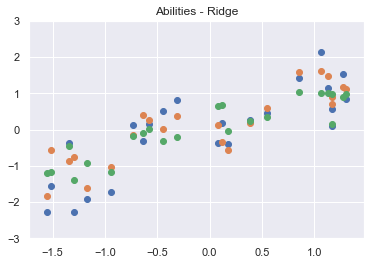

In [121]:
resplot(0,0)

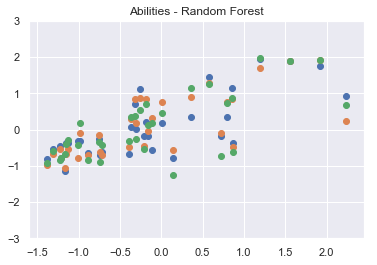

In [108]:
resplot(0,1)

In [109]:
feat[0].sort_values('mean',ascending=False)

0         1         2      mean       std
Written Comprehension        0.740948  0.229892  0.615675  0.528838  0.217486
Glare Sensitivity            0.028175  0.476317  0.537384  0.347292  0.227023
Depth Perception             0.465026  0.228793  0.252754  0.315525  0.106165
Stamina                      0.265512  0.490935  0.188371  0.314939  0.128371
Manual Dexterity             0.401056  0.146872  0.285970  0.277966  0.103925
Information Ordering         0.061958  0.070685  0.450452  0.194365  0.181116
Gross Body Equilibrium       0.150535  0.259063  0.154889  0.188162  0.050166
Problem Sensitivity         -0.062606  0.215877  0.330164  0.161145  0.164952
Mathematical Reasoning       0.173826  0.091610  0.187600  0.151012  0.042379
Explosive Strength           0.066548  0.170229  0.164867  0.133881  0.047662
Rate Control                 0.169275  0.067240  0.159524  0.132013  0.045974
Control Precision            0.131820  0.178413  0.060598  0.123611  0.048447
Deductive Reasoning          0.269025  0.206206 -0.104818  0.123471  0.163449
Extent Flexibility           0.057248  0.374639 -0.074324  0.119188  0.188449
Inductive Reasoning          0.077542  0.248424  0.009373  0.111780  0.100550
Response Orientation         0.233455  0.099114 -0.007055  0.108505  0.098412
Near Vision                  0.181058  0.062534  0.037351  0.093647  0.062658
Originality                 -0.001877  0.454886 -0.226391  0.075539  0.283466
Oral Comprehension           0.295244  0.017370 -0.156622  0.051998  0.186091
Hearing Sensitivity          0.023037  0.063225  0.049462  0.045241  0.016676
Selective Attention          0.095611 -0.062508  0.095624  0.042909  0.074541
Visual Color Discrimination -0.185802  0.154239  0.159268  0.042568  0.161496
Flexibility of Closure       0.033011 -0.009955  0.094661  0.039239  0.042936
Speed of Closure             0.171397  0.002496 -0.064063  0.036610  0.099107
Peripheral Vision           -0.142020  0.031914  0.204407  0.031434  0.141428
Spatial Orientation          0.110133  0.000762 -0.026092  0.028268  0.058917
Speech Clarity               0.281689  0.192256 -0.394232  0.026571  0.299784
Far Vision                   0.007472  0.073909 -0.015034  0.022116  0.037759
Written Expression          -0.199998  0.136664  0.113796  0.016821  0.153598
Speech Recognition          -0.125926 -0.106199  0.276060  0.014645  0.185024
Visualization                0.158541  0.047678 -0.176226  0.009998  0.139241
Multilimb Coordination       0.003401 -0.253339  0.254455  0.001506  0.207310
Static Strength              0.266019 -0.336418  0.001877 -0.022840  0.246564
Memorization                 0.021170 -0.113170  0.021350 -0.023550  0.063371
Sound Localization          -0.068374  0.042189 -0.078434 -0.034873  0.054646
Perceptual Speed            -0.029466  0.021999 -0.121767 -0.043078  0.059476
Wrist-Finger Speed          -0.079948 -0.007933 -0.074751 -0.054211  0.032792
Gross Body Coordination     -0.089041 -0.268147  0.128495 -0.076231  0.162182
Auditory Attention           0.035749 -0.245206 -0.050227 -0.086561  0.117542
Oral Expression             -0.376394  0.119024 -0.015675 -0.091015  0.209152
Dynamic Flexibility         -0.177114 -0.124972  0.017642 -0.094815  0.082319
Category Flexibility        -0.173132 -0.081268 -0.051984 -0.102128  0.051611
Number Facility             -0.232016 -0.061592 -0.083503 -0.125704  0.075705
Time Sharing                -0.111304 -0.120878 -0.154524 -0.128902  0.018534
Finger Dexterity            -0.138134 -0.231471 -0.051332 -0.140312  0.073558
Fluency of Ideas            -0.031980 -0.555210  0.159144 -0.142682  0.301957
Speed of Limb Movement      -0.250975 -0.048414 -0.163420 -0.154270  0.082948
Trunk Strength              -0.168403 -0.166597 -0.156566 -0.163855  0.005207
Arm-Hand Steadiness         -0.446690  0.038837 -0.156744 -0.188199  0.199459
Dynamic Strength            -0.205597 -0.313454 -0.201935 -0.240329  0.051729
Night Vision                -0.102596 -0.364515 -0.396735 

In [75]:
result[0]

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


({'fit_time': array([0.00152993, 0.00153017, 0.00150394]),
  'score_time': array([0.00073695, 0.00069904, 0.00073409]),
  'estimator': (Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001),
   Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001),
   Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)),
  'test_score': array([0.60047947, 0.43499273, 0.46112681]),
  'train_score': array([0.85078108, 0.86309015, 0.87693482])},
 {'fit_time': array([0.05339003, 0.05450392, 0.05184007]),
  'score_time': array([0.00285602, 0.0026648 , 0.0025878 ]),
  'estimator': (RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
  

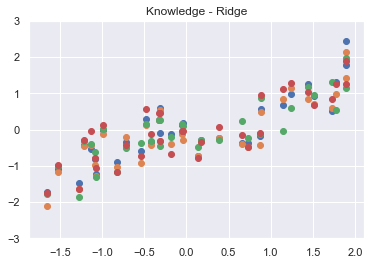

In [89]:
resplot(1,0)

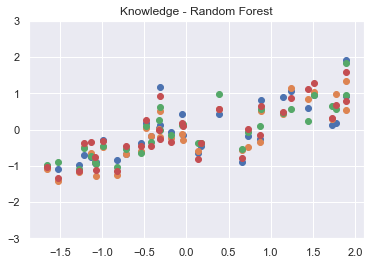

In [90]:
resplot(1,1)

In [69]:
result[1][2]['estimator']

IndexError: tuple index out of range

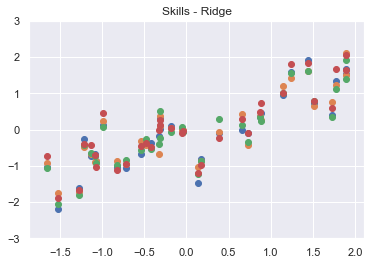

In [91]:
resplot(2,0)

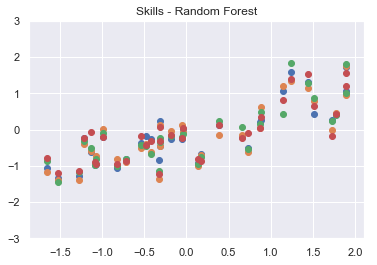

In [92]:
resplot(2,1)

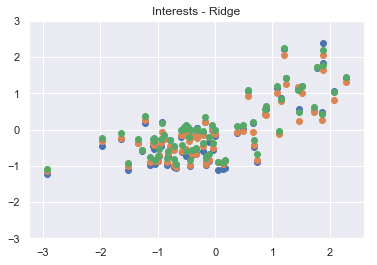

In [61]:
resplot(3,0)

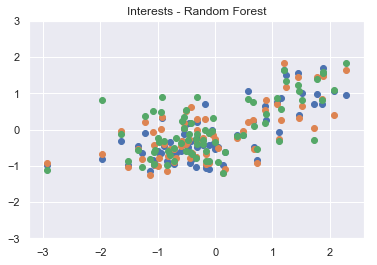

In [62]:
resplot(3,1)

In [80]:
for ft in range(len(featuresets)):
    X, y = xy(featuresets[ft],occupations)
    res = cross_validate(rf,X, y, cv=n, return_estimator=True)
    result[ft] = res
    feat[ft] = pd.DataFrame(res['estimator'][0].feature_importances_,index=X.columns)
    for i in range(n):
        feat[ft][i] = pd.DataFrame(res['estimator'][i].feature_importances_,index=X.columns)
    feat[ft]['mean'] = feat[ft].mean(axis=1)
    feat[ft]['std'] = feat[ft].std(axis=1)


In [81]:
feat[0].sort_values('mean',ascending = False).head()

0         1         2      mean       std
Information Ordering   0.057330  0.054371  0.462524  0.191408  0.191712
Deductive Reasoning    0.101301  0.261099  0.140320  0.167573  0.068024
Written Comprehension  0.070526  0.206204  0.021251  0.099327  0.078205
Inductive Reasoning    0.114409  0.086960  0.051871  0.084413  0.025595
Oral Comprehension     0.072506  0.019618  0.010725  0.034283  0.027271

In [82]:
for ft in range(len(featuresets)):
    X, y = xy(featuresets[ft],occupations)
    res = cross_validate(reg_ridge,X, y, cv=n, return_estimator=True)
    result[ft] = res
    feat[ft] = pd.DataFrame(res['estimator'][0].coef_,index=X.columns)
    for i in range(n):
        feat[ft][i] = pd.DataFrame(res['estimator'][i].coef_,index=X.columns)
    feat[ft]['mean'] = feat[ft].mean(axis=1)
    feat[ft]['std'] = feat[ft].std(axis=1)


In [83]:
feat[0].sort_values('mean',ascending = False).head()

0         1         2      mean       std
Written Comprehension   0.486088  0.208410  0.499608  0.398035  0.134199
Depth Perception        0.320566  0.338598  0.309226  0.322797  0.012094
Control Precision       0.162397  0.168638  0.389860  0.240298  0.105787
Glare Sensitivity       0.459667  0.247599 -0.020297  0.228989  0.196386
Gross Body Equilibrium  0.387483  0.209516  0.049998  0.215666  0.137847

In [84]:
feat[1].sort_values('mean',ascending = False).head()

0         1         2      mean       std
Physics                     0.206371  0.335668  0.310081  0.284040  0.055905
Law and Government          0.102732  0.354099  0.273637  0.243490  0.104811
Computers and Electronics   0.122966  0.203627  0.370128  0.232240  0.102912
English Language            0.097209  0.281729  0.146568  0.175169  0.077998
Sociology and Anthropology -0.074259  0.127507  0.453350  0.168866  0.217372

In [124]:
clab = OnetCluster(matrix(dab),2)

In [125]:
clab.

TypeError: 'OnetCluster' object does not support indexing

In [134]:
featuresets = [dab,dkn,dsk,din]
clst = {}
for k in range(len(featuresets)):
    clst[k]={}
    for l in range(1,6):
        clst[k][l]=OnetCluster(matrix(featuresets[k]),l)

In [135]:
clst[0][1]

In [138]:
clab.ph

Arm-Hand Steadiness  Auditory Attention  Category Flexibility  \
0             0.610538            1.068485              2.363440   
1             1.880095            1.273073              0.653466   

   Control Precision  Deductive Reasoning  Depth Perception  \
0           0.482827             2.745784          0.500240   
1           2.019297             0.529831          1.572411   

   Dynamic Flexibility  Dynamic Strength  Explosive Strength  \
0             0.000000          0.000000            0.001130   
1             0.227517          1.535996            0.564115   

   Extent Flexibility         ...          Speed of Limb Movement   Stamina  \
0             0.00000         ...                        0.000000  0.007858   
1             2.05125         ...                        1.212485  1.594094   

   Static Strength  Time Sharing  Trunk Strength  Visual Color Discrimination  \
0         0.001383      1.632703        0.558516                     1.291670   
1         2.069301      0.851122        1.744369                     1.192165   

   Visualization  Wrist-Finger Speed  Written Comprehension  \
0       1.672883            0.179178               2.973809   
1       1.168155            1.210254               0.342075   

   Written Expression  
0            2.907192  
1            0.096355  

[2 rows x 52 columns]

In [178]:

class OnetCluster:
    def __init__(self,X,n):
        self.X = X
        self.model = NMF(n_components=n, init='random', random_state=0, max_iter = 1000, tol = 0.0000001)
        self.w = self.model.fit_transform(X)
        self.o = pd.DataFrame(self.w,index=X.index)
        self.on = nrmcol(self.o.T).T
        self.h = self.model.components_
        self.f = pd.DataFrame(self.h,columns=X.columns)
        self.fn = nrmcol(self.f.T).T
    


class Svd:
    def __init__(self,X):
        self.u,self.s,self.vt = svd(np.array(X))
        self.f = pd.DataFrame(self.vt,columns=X.columns)
        self.o = pd.DataFrame(self.u,columns=X.index)

In [153]:
clab = OnetCluster(matrix(dab),3)

In [179]:
svab = Svd(matrix(dab))

In [185]:
svab.o[:20].T

0         1         2         3         4         5   \
SOCP_shave                                                               
111011     -0.036923 -0.034640 -0.034205 -0.034284 -0.034272 -0.033866   
111021      0.055868  0.017374  0.053371  0.054526  0.047734  0.055176   
112011     -0.019121 -0.034487 -0.014161 -0.023035 -0.026227 -0.029221   
112021      0.024941  0.001045  0.008182  0.013361  0.019234 -0.000232   
112022     -0.025318 -0.010647 -0.030026 -0.051348 -0.020033 -0.004832   
112031     -0.002772  0.021873 -0.018357 -0.003456  0.013203 -0.004737   
113011     -0.000070  0.004280 -0.005146 -0.036404  0.011135 -0.014650   
113021      0.045584  0.056522  0.034968  0.027962 -0.001069  0.034253   
113031      0.010386  0.012274 -0.055075 -0.059771 -0.018373 -0.062354   
113051      0.029973  0.037755  0.004379 -0.007917 -0.008622 -0.012268   
113061      0.023552  0.029865 -0.049581 -0.010063  0.061057  0.005541   
113071      0.016436 -0.036757 -0.006746 -0.015666 -0.033943 -0.006722   
113111     -0.038790 -0.022127  0.052789  0.061151  0.019463  0.017454   
113121      0.082996 -0.030578  0.015580 -0.016848  0.031576  0.004646   
113131      0.023333 -0.032711 -0.023213 -0.014360 -0.008103 -0.011273   
119013     -0.015380 -0.024037  0.007412  0.021168  0.011502 -0.008555   
119021      0.090349 -0.048466  0.005433  0.009771 -0.008332  0.024781   
119031      0.011938  0.027161  0.023562  0.019973  0.030707  0.033616   
119032     -0.013463 -0.001393  0.017665 -0.007711  0.005499  0.011002   
119033      0.024302 -0.083993 -0.015642 -0.011314  0.048038  0.003924   
119039      0.022475  0.026103  0.060946  0.035708  0.022751  0.021363   
119041      0.017302 -0.036900 -0.005602 -0.001538 -0.004223  0.018769   
119051     -0.054899  0.010267 -0.019706 -0.035434  0.003585 -0.045162   
119061      0.056946  0.019502  0.019013  0.012224  0.042292 -0.010488   
119071      0.014891  0.034690 -0.046655 -0.024499 -0.038048  0.042921   
119081     -0.009547  0.062908 -0.035638  0.004670 -0.020624  0.011721   
119111      0.015185 -0.014227 -0.046710 -0.018801 -0.001457  0.003581   
119121      0.061420 -0.030098  0.006002  0.008225  0.022673  0.013972   
119131      0.000485  0.038668  0.002184 -0.035215 -0.027158  0.000240   
119141     -0.023575 -0.046202  0.011000  0.002239 -0.021502 -0.002981   
...              ...       ...       ...       ...       ...       ...   
534021     -0.040890 -0.039720  0.050314  0.023208  0.024306  0.024371   
534031     -0.041872 -0.055169  0.040827 -0.019444 -0.041949 -0.016849   
534041     -0.036990 -0.036041  0.057473  0.047662 -0.035984  0.034476   
535011     -0.041802 -0.062995  0.060791  0.006082  0.018525 -0.046602   
535021     -0.037686 -0.034919  0.028677  0.043502 -0.027690 -0.028738   
535022     -0.037129  0.019363  0.047787  0.041629 -0.000264  0.001296   
535031     -0.046088 -0.027823  0.039292  0.019154 -0.029734  0.070190   
536011     -0.024651 -0.019544  0.019451  0.049532  0.022452 -0.018689   
536021     -0.037355  0.001942  0.002334  0.058261  0.024664 -0.033971   
536031     -0.038813 -0.005911  0.020178 -0.003586  0.004892  0.013768   
536041     -0.034566  0.002406 -0.009979  0.025808 -0.035713  0.024387   
536051     -0.038517 -0.017045  0.016200 -0.000370  0.004963 -0.033213   
536061     -0.028071  0.005885 -0.009111 -0.002476  0.028715  0.012045   
537011     -0.042936  0.007540  0.024325  0.029579  0.015457 -0.010595   
537021     -0.042087 -0.033115  0.019196  0.047405 -0.037146 -0.080909   
537031     -0.037985 -0.022342  0.065994  0.037703 -0.010828 -0.027115   
537032     -0.056167 -0.058455  0.060848  0.003810  0.011143 -0.027545   
537033     -0.051462 -0.000085  0.000630  0.051040  0.068092 -0.033265   
537041     -0.046368 -0.027057  0.036448  0.069299  0.047107 -0.035232   
537051     -0.045169 -0.040125  0.044405  0.043631 -0.010428 -0.075195   
537061     -0.055858  0.038362 -0.031869  0.066694 -0.021196 -0.042680   
537062     -0.051448 -

In [187]:
xy(svab.o[:20].T,occupations)

KeyError: 'Element Name'

In [215]:

def matrix(features):
    # Build X: occupation/feature matrix from O*NET
    foo = pd.get_dummies(features['Element Name']) 
    occ_features = features[['O*NET-SOC Code']].join(foo.multiply(features['Data Value'],axis = "index")).groupby('O*NET-SOC Code').sum()
    occ_features['SOCP'] = occ_features.index
    occ_features['SOCP_shave']=occ_features['SOCP'].apply(soc)
    # Group by census/PUMS SOC codes (SOCP_shave)
    occ_features_compounded= occ_features.groupby('SOCP_shave').mean()
    occ_features_compounded['SOCP_shave'] = occ_features_compounded.index   
    foo = occ_features_compounded.drop(columns='SOCP_shave')
    return foo

def xy(features,occupations):
    #Normalizes occupation matrix
    #foo = matrix(features)
    foo = features
    occ_features_norm = (foo - foo.mean())/foo.std()
    

    # Normalize y:  Census/PUMS log FTE wages   
    foo = occupations[['SOCP_shave','Occupation','FTE wage','log FTE']].copy()
    foo['log FTE'] =norm(occupations['log FTE'])

    # Merge and align X & y for occupations
    fit_data = foo.merge(occ_features_norm,left_on='SOCP_shave',right_index=True)
    
    # Return X & y
    y = fit_data['log FTE']
    X = fit_data.drop(columns = ['SOCP_shave', 'Occupation', 'FTE wage', 'log FTE'])
    return (X,y)


In [211]:
matrix(dab)

Arm-Hand Steadiness  Auditory Attention  Category Flexibility  \
SOCP_shave                                                                  
111011                 0.000000            1.870000              3.870000   
111021                 1.500000            2.000000              3.000000   
112011                 0.500000            1.250000              3.880000   
112021                 0.120000            1.620000              3.620000   
112022                 0.500000            1.880000              3.620000   
112031                 0.000000            1.500000              3.380000   
113011                 2.000000            2.250000              3.120000   
113021                 2.000000            1.750000              3.120000   
113031                 0.125000            1.560000              3.560000   
113051                 2.500000            2.875000              3.458333   
113061                 0.000000            1.880000              3.750000   
113071                 1.250000            2.040000              3.460000   
113111                 0.500000            1.000000              3.000000   
113121                 0.500000            1.620000              3.750000   
113131                 0.880000            2.000000              3.620000   
119013                 2.790000            2.420000              3.456667   
119021                 0.620000            3.000000              3.500000   
119031                 1.880000            2.000000              3.120000   
119032                 0.500000            2.120000              4.000000   
119033                 0.120000            1.380000              3.750000   
119039                 1.560000            2.130000              3.380000   
119041                 2.125000            2.375000              3.815000   
119051                 2.880000            2.620000              3.120000   
119061                 2.120000            1.750000              3.000000   
119071                 0.620000            2.750000              3.250000   
119081                 2.250000            2.000000              3.000000   
119111                 0.880000            2.000000              3.250000   
119121                 0.000000            1.916667              3.623333   
119131                 0.380000            2.120000              3.000000   
119141                 0.000000            1.380000              3.120000   
...                         ...                 ...                   ...   
534021                 2.630000            3.500000              2.630000   
534031                 2.880000            3.880000              3.120000   
534041                 2.750000            3.500000              2.630000   
535011                 3.120000            3.880000              3.000000   
535021                 3.123333            3.246667              3.126667   
535022                 3.130000            3.380000              2.630000   
535031                 3.250000            3.380000              3.250000   
536011                 2.500000            2.750000              2.630000   
536021                 2.120000            2.250000              2.620000   
536031                 3.000000            2.750000              2.380000   
536041                 2.500000            2.380000              3.250000   
536051                 2.833333            2.790000              3.170000   
536061                 2.120000            2.380000              2.880000   
537011                 3.120000            3.000000              3.000000   
537021                 3.120000            2.880000              2.500000   
537031                 3.120000            3.380000              2.250000   
537032                 3.120000            4.120000              2.880000   
537033                 3.250000            2.750000              3.120000   
537041                 2.630000            2.880000              2.630000   
537051  

In [217]:
X,y = xy(svab.o[:10].T.copy(),occupations)

# SVD  All features

In [297]:
foo = pd.concat([matrix(dab),matrix(dkn),matrix(dsk)],axis=1)
svall = Svd(foo)

In [317]:

fit = {}
feat = {}
result = {}
Xy_test= {}
n=3
featuresets = [svall.o[:i].T for i in [16,24,32,40,48]]
for ft in range(len(featuresets)):
    X, y = xy(featuresets[ft],occupations)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    Xy_test[ft]=(X_test,y_test)
    res = cross_validate(reg_ridge,X_train, y_train, cv=n, return_estimator=True)
    res_rf = cross_validate(rf,X_train, y_train, cv=n, return_estimator=True)
    res_boo = cross_validate(boo,X_train, y_train, cv=n, return_estimator=True)
    result[ft] = (res,res_rf,boo)
    feat[ft] = pd.DataFrame(res['estimator'][0].coef_,index=X.columns)
    for i in range(n):
        feat[ft][i] = pd.DataFrame(res['estimator'][i].coef_,index=X.columns)
    feat[ft]['mean'] = feat[ft].mean(axis=1)
    feat[ft]['std'] = feat[ft].std(axis=1)


def resplot(f,e):
    plt.scatter(x=Xy_test[f][1],y=result[f][e]['estimator'][0].predict(Xy_test[f][0]))
    plt.scatter(x=Xy_test[f][1],y=result[f][e]['estimator'][1].predict(Xy_test[f][0]))
    plt.scatter(x=Xy_test[f][1],y=result[f][e]['estimator'][2].predict(Xy_test[f][0]))
    #plt.scatter(x=Xy_test[f][1],y=result[f][e]['estimator'][3].predict(Xy_test[f][0]))
    plt.ylim(-3,3)
    #plt.title(featurenames[f]+' - '+ methodnames[e])

In [318]:
result[0][0]['estimator'][0].score(Xy_test[0][0],Xy_test[0][1])

-0.22958666088376667

In [319]:
result[1][0]['estimator'][0].score(Xy_test[1][0],Xy_test[1][1])

-0.14349391620734542

In [322]:
result[2][0]['estimator'][0].score(Xy_test[2][0],Xy_test[2][1])

0.007519385123046618

In [323]:
result[3][0]['estimator'][0].score(Xy_test[3][0],Xy_test[3][1])

0.04263056856887104

In [299]:
result

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{0: ({'fit_time': array([0.00202394, 0.00164008, 0.00170898]),
   'score_time': array([0.00116301, 0.00086379, 0.00085592]),
   'estimator': (Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
       normalize=False, random_state=None, solver='auto', tol=0.001),
    Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
       normalize=False, random_state=None, solver='auto', tol=0.001),
    Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
       normalize=False, random_state=None, solver='auto', tol=0.001)),
   'test_score': array([0.10774201, 0.11619902, 0.1182839 ]),
   'train_score': array([0.14412839, 0.14310331, 0.14095666])},
  {'fit_time': array([0.04517817, 0.05619097, 0.03525591]),
   'score_time': array([0.00613403, 0.00547099, 0.00346684]),
   'estimator': (RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
               max_features='auto', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impur

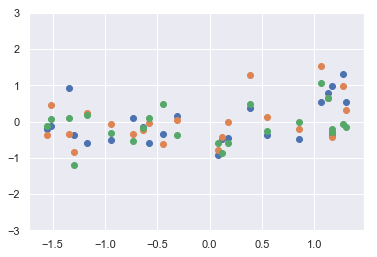

In [265]:
resplot(1,1)

In [250]:
svab = Svd(matrix(dab))

In [269]:
foo = pd.concat([matrix(dab),matrix(dkn),matrix(dsk)],axis=1)

In [270]:
svall = Svd(foo)

# NMF All

In [344]:
OnetCluster(foo,50)

In [358]:
0.7**2

0.48999999999999994

In [345]:
clall = [OnetCluster(foo,n) for n in [2,4,8,16,32,64,128,256]]

In [401]:
clcat[0][1]

1
SOCP_shave          
113051      0.711129
119013      0.793214
131074      0.811305
151151      0.705476
171022      0.730675
173021      0.827498
173023      0.835634
173024      0.956965
173025      0.845754
173026      0.721275
173027      0.903307
173029      0.844979
173031      0.740718
191032      0.702628
192031      0.715518
194011      0.745720
194021      0.741224
194031      0.882589
194041      0.804081
194051      0.889810
194091      0.783977
194092      0.750639
194093      0.878635
194099      0.714662
254013      0.700558
271012      0.884675
271013      0.720545
271026      0.767505
271027      0.715134
272021      0.878092
...              ...
534021      0.984670
534031      0.907557
534041      0.969256
535011      0.987410
535021      0.935150
535022      0.971176
535031      0.957361
536011      0.955890
536021      0.936240
536031      0.966785
536041      0.742988
536051      0.900621
536061      0.804716
537011      0.985461
537021      0.993262
537031      0.994913
537032      0.997016
537033      0.997100
537041      0.996555
537051      0.995253
537061      0.986784
537062      0.993998
537063      0.971460
537064      0.929605
537071      0.971197
537072      0.971091
537073      0.994639
537081      0.983679
537111      0.999672
537121      0.995399

[392 rows x 1 columns]

In [399]:
clall[2].fn.iloc[0].sort_values(ascending=False)

Design                               0.410934
Building and Construction            0.349372
Engineering and Technology           0.311199
Production and Processing            0.251984
Mechanical                           0.248995
Sales and Marketing                  0.224461
Administration and Management        0.213421
Economics and Accounting             0.181595
Personnel and Human Resources        0.180100
Management of Financial Resources    0.155953
Management of Material Resources     0.151344
Physics                              0.150126
Transportation                       0.149174
Customer and Personal Service        0.148045
Public Safety and Security           0.141847
Mathematics                          0.133893
Chemistry                            0.122096
Visualization                        0.112754
Clerical                             0.109023
Operations Analysis                  0.105696
Geography                            0.095997
Education and Training            

In [461]:
def clocc(n_order,m_cluster):
    soccs = clcat[n_order][m_cluster][clcat[n_order][m_cluster] > 0.7]
    cloccs = soccs.merge(occupations,left_index=True, right_index=True).dropna()
    return cloccs
    

In [476]:
xy(dall,clocc(1,1))

(        Arm-Hand Steadiness  Auditory Attention  Category Flexibility  \
 211092            -0.865817           -0.362015             -0.092820   
 211093            -0.434171            0.190594             -0.335171   
 259041            -1.081640           -0.187507             -0.840070   
 291031            -1.944933           -0.536523              1.442071   
 291051             0.429122           -0.362015              1.926773   
 291071             1.024794            0.096069              0.795801   
 291122             0.325527            0.088798              0.169727   
 291123             0.644945           -0.725573              1.179523   
 291124             1.076592           -0.187507              0.674625   
 291125             0.570127            0.064561              0.001427   
 291126             0.748540            0.728661              0.432274   
 291127            -0.865817            1.266727              0.916976   
 291141             0.128696          

In [473]:
len(clcat[1])

4

In [480]:
[dall[col] for col in dall.columns]

[SOCP_shave
 111011    0.000000
 111021    1.500000
 112011    0.500000
 112021    0.120000
 112022    0.500000
 112031    0.000000
 113011    2.000000
 113021    2.000000
 113031    0.125000
 113051    2.500000
 113061    0.000000
 113071    1.250000
 113111    0.500000
 113121    0.500000
 113131    0.880000
 119013    2.790000
 119021    0.620000
 119031    1.880000
 119032    0.500000
 119033    0.120000
 119039    1.560000
 119041    2.125000
 119051    2.880000
 119061    2.120000
 119071    0.620000
 119081    2.250000
 119111    0.880000
 119121    0.000000
 119131    0.380000
 119141    0.000000
             ...   
 534021    2.630000
 534031    2.880000
 534041    2.750000
 535011    3.120000
 535021    3.123333
 535022    3.130000
 535031    3.250000
 536011    2.500000
 536021    2.120000
 536031    3.000000
 536041    2.500000
 536051    2.833333
 536061    2.120000
 537011    3.120000
 537021    3.120000
 537031    3.120000
 537032    3.120000
 537033    3.250000
 537041 

In [483]:
fit = {}
feat = {}
result = {}
Xy_test= {}
n=3

ftrs = [dall[[col]] for col in dall.columns]
for n_order in [0,1]:
    for m_cluster in range(n_order + 1):
        for ft in dall.columns:
            X, y = xy(dall[[ft]],clocc(n_order,m_cluster))
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=37)
            Xy_test[ft]=(X_test,y_test)
            res = cross_validate(reg_ridge,X_train, y_train, cv=n, return_estimator=True)
            res_rf = cross_validate(rf,X_train, y_train, cv=n, return_estimator=True)
            result[ft] = (res,res_rf,boo)
            feat[ft] = pd.DataFrame(res['estimator'][0].coef_,index=X.columns)
            for i in range(n):
                feat[ft][i] = pd.DataFrame(res['estimator'][i].coef_,index=X.columns)
            feat[ft]['mean'] = feat[ft].mean(axis=1)
            feat[ft]['std'] = feat[ft].std(axis=1)




In [489]:
Xy_test[foo[0]][1]

291123    0.646732
291071    1.011465
291122    0.301628
Name: log FTE, dtype: float64

In [491]:
foo = dall.columns
bar = result[foo[0]]

In [510]:
col = foo[0]
col

'Arm-Hand Steadiness'

In [523]:
str(result[col][0]['estimator'][1])[:7]

'Ridge(a'

In [559]:
def ffm():
    res = pd.DataFrame({col : fm(col) for col in dall.columns}).loc['Random'].sort_values()
    return res

def fm(col):
    return { ['Ridge','Random'][m]: np.std([
        result[col][m]['estimator'][es].score(Xy_test[col][0],Xy_test[col][1]) for es in range(3)])
         for m in [0,1]} 

In [560]:
ffm()

Information Ordering                  0.147197
Judgment and Decision Making          0.164848
Flexibility of Closure                0.169077
Complex Problem Solving               0.398992
Medicine and Dentistry                0.399095
Technology Design                     0.420171
Written Comprehension                 0.728471
Deductive Reasoning                   0.790079
Problem Sensitivity                   0.812245
Speed of Closure                      0.862873
Oral Comprehension                    0.891454
Instructing                           0.917408
Visual Color Discrimination           0.928127
Visualization                         0.988803
Design                                1.000710
Management of Personnel Resources     1.094062
Science                               1.140379
Building and Construction             1.181748
Systems Evaluation                    1.277385
Speech Clarity                        1.280862
Psychology                            1.292558
Systems Analy

In [534]:
pd.DataFrame({col : { ['Ridge','Random'][m]: np.std([
    result[col][m]['estimator'][es].score(Xy_test[col][0],Xy_test[col][1]) for es in range(3)])
     for m in [0,1]} for col in dall.columns}).loc['Random'].sort_values()

Information Ordering                  0.147197
Judgment and Decision Making          0.164848
Flexibility of Closure                0.169077
Complex Problem Solving               0.398992
Medicine and Dentistry                0.399095
Technology Design                     0.420171
Written Comprehension                 0.728471
Deductive Reasoning                   0.790079
Problem Sensitivity                   0.812245
Speed of Closure                      0.862873
Oral Comprehension                    0.891454
Instructing                           0.917408
Visual Color Discrimination           0.928127
Visualization                         0.988803
Design                                1.000710
Management of Personnel Resources     1.094062
Science                               1.140379
Building and Construction             1.181748
Systems Evaluation                    1.277385
Speech Clarity                        1.280862
Psychology                            1.292558
Systems Analy

In [509]:

{col : [result[col][0]['estimator'][es].score(Xy_test[col][0],Xy_test[col][1])] for es in [0,1] for col in dall.columns}

{'Arm-Hand Steadiness': [-0.21423020188756037],
 'Auditory Attention': [-2.6429781783706363],
 'Category Flexibility': [-0.054110080793297266],
 'Control Precision': [-0.16344640350824235],
 'Deductive Reasoning': [0.3491245802829285],
 'Depth Perception': [-1.50507574620111],
 'Dynamic Flexibility': [-2.7941221324567995],
 'Dynamic Strength': [-1.0657996402350807],
 'Explosive Strength': [-1.3590006764030687],
 'Extent Flexibility': [-1.0312414269523633],
 'Far Vision': [-1.5114909696519017],
 'Finger Dexterity': [-0.3588229579886384],
 'Flexibility of Closure': [0.9006363482391634],
 'Fluency of Ideas': [-1.9059250907035072],
 'Glare Sensitivity': [-1.846147795563697],
 'Gross Body Coordination': [-3.3438330146808903],
 'Gross Body Equilibrium': [-2.348563185093454],
 'Hearing Sensitivity': [-2.440665256651913],
 'Inductive Reasoning': [0.4227430104981921],
 'Information Ordering': [-0.012293558534411497],
 'Manual Dexterity': [0.14689286294133141],
 'Mathematical Reasoning': [0.1908

In [292]:
result

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{0: ({'fit_time': array([0.00234795, 0.00177193, 0.00160789]),
   'score_time': array([0.00100994, 0.00084209, 0.00132203]),
   'estimator': (Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
       normalize=False, random_state=None, solver='auto', tol=0.001),
    Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
       normalize=False, random_state=None, solver='auto', tol=0.001),
    Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
       normalize=False, random_state=None, solver='auto', tol=0.001)),
   'test_score': array([0.59053644, 0.61512712, 0.59838252]),
   'train_score': array([0.62446037, 0.61500875, 0.62060995])},
  {'fit_time': array([0.02637577, 0.02678776, 0.03358006]),
   'score_time': array([0.00303221, 0.00307202, 0.00543213]),
   'estimator': (RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
               max_features='auto', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impur

In [333]:
result[0][0]['estimator'][1].score(Xy_test[0][0],Xy_test[0][1])

0.6808415626444686

In [336]:
result[1][0]['estimator'][1].score(Xy_test[1][0],Xy_test[1][1])

0.7113599652509737

In [337]:
result[2][0]['estimator'][1].score(Xy_test[2][0],Xy_test[2][1])

0.6939023132605344

In [338]:
result[3][0]['estimator'][1].score(Xy_test[3][0],Xy_test[3][1])

0.6917599210830925

In [ ]:
fit = {}
feat = {}
result = {}
Xy_test= {}
n=3
featuresets = [clall[i].o for i in range(len(clall))]
for ft in range(len(featuresets)):
    X, y = xy(featuresets[ft],occupations)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=37)
    Xy_test[ft]=(X_test,y_test)
    res = cross_validate(reg_ridge,X_train, y_train, cv=n, return_estimator=True)
    res_rf = cross_validate(rf,X_train, y_train, cv=n, return_estimator=True)
    #res_boo = cross_validate(boo,X_train, y_train, cv=n, return_estimator=True)
    result[ft] = (res,res_rf,boo)
    feat[ft] = pd.DataFrame(res['estimator'][0].coef_,index=X.columns)
    for i in range(n):
        feat[ft][i] = pd.DataFrame(res['estimator'][i].coef_,index=X.columns)
    feat[ft]['mean'] = feat[ft].mean(axis=1)
    feat[ft]['std'] = feat[ft].std(axis=1)



